In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import numpy as np
from rmab.utils import get_results_matching_parameters
from rmab.plots import aggregate_data, aggregate_normalize_data
import seaborn as sns
from rmab.fr_dynamics import get_all_transitions
import random 
import math
from copy import deepcopy

/usr0/home/naveenr/miniconda3/envs/food/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')


In [4]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.rcParams['savefig.bbox'] = 'tight'

In [5]:
colors_by_method = {}
baseline_methods = ['random','whittle_activity','greedy','mcts','dqn_step','dqn']
whittle_methods = ['linear_whittle','shapley_whittle_custom']
iterative_methods = ['iterative_whittle','shapley_iterative_whittle']
mcts = ['mcts_linear','mcts_shapley']
non_baselines = whittle_methods + iterative_methods
time_policies = ["shapley_iterative_whittle_100","shapley_iterative_whittle_10","shapley_iterative_whittle_1", "mcts_shapley_40","mcts_shapley_4"]

greys = plt.cm.Greys(np.linspace(0, 1, len(baseline_methods)+1))
vidris = plt.cm.coolwarm(np.linspace(0, 1, len(whittle_methods) + len(iterative_methods)))
wistia = plt.cm.Wistia(np.linspace(0, 1, len(mcts)))
winter = plt.cm.spring(np.linspace(0, 1, len(time_policies)))


for i,m in enumerate(baseline_methods):
    colors_by_method[m] = greys[i+1]
for i,m in enumerate(non_baselines):
    colors_by_method[m] = vidris[i]
for i,m in enumerate(mcts):
    colors_by_method[m] = wistia[i]
for i,m in enumerate(time_policies):
    colors_by_method[m] = winter[i] 
colors_by_method['optimal'] = np.array([0.9,0.05,0.05,1.0])

In [7]:
shapes_by_method = {}
all_shapes = ['P','o','v','D','s','x','^','<','>']
for i,m in enumerate(non_baselines+mcts+time_policies):
    shapes_by_method[m] = all_shapes[i%len(all_shapes)]

## NeurIPS 2024 Plots

### Budget and Number of Arms

### Baselines

0.9495491492164236
0.9598712579858426
0.961450256919471
0.959131887417234


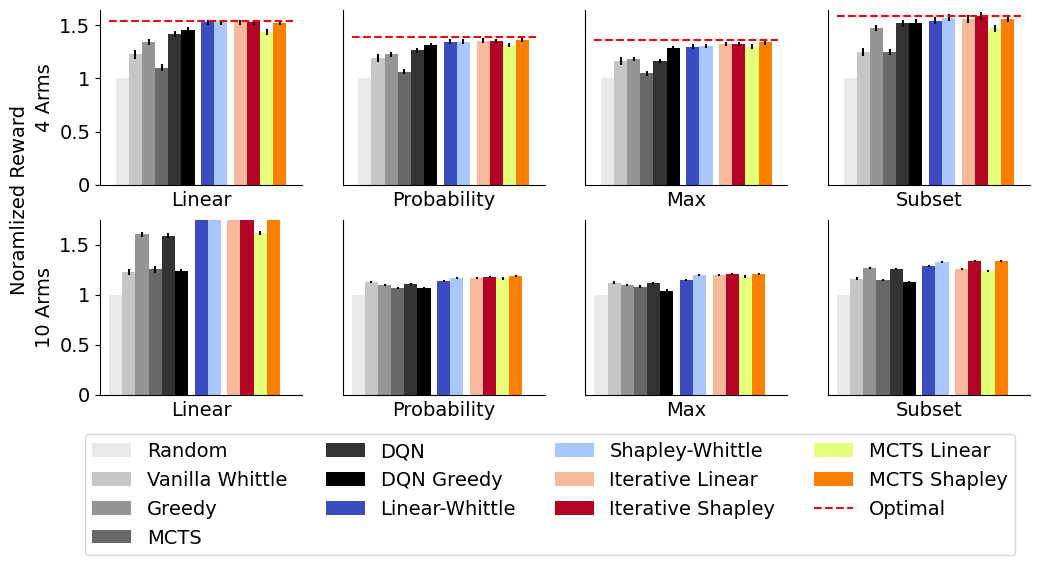

<Figure size 700x400 with 0 Axes>

In [7]:
fig, axs = plt.subplots(2,4, figsize=(12, 5))
method_names = ['random','whittle_activity','greedy','mcts','dqn_step','dqn','linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley','optimal']
nice_names = ["Random","Vanilla Whittle","Greedy","MCTS","DQN","DQN Greedy","Linear-Whittle","Shapley-Whittle","Iterative Linear","Iterative Shapley","MCTS Linear","MCTS Shapley","Optimal"]
width = 0.1
plt.figure(figsize=(7,4))
n_arms = [4,10]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 2, 'n_arms': 4, 'time_limit': 100,'prob_distro': 'uniform','n_episodes': 105}
datasets = ['linear_reward','prob_reward','max_reward','subset_reward']
reward_names = ["Linear","Probability","Max","Subset"]
params = [{'reward_type': 'linear','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'probability','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'max', 'arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'set_cover', 'universe_size': 20, 'arm_set_low': 6, 'arm_set_high': 8}, ]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names[i] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((i+shift)*width)

for i,n in enumerate(n_arms):
    for j in range(len(reward_names)):
        baseline_params['n_arms'] = n
        baseline_params['budget'] = n//2 

        best_baseline = 0

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            dataset = "baselines/all"

            if m in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley','optimal']:
                dataset = "reward_variation/{}".format(datasets[j])

            temp_params = deepcopy(baseline_params)
            for p in params[j]:
                temp_params[p] = params[j][p]
                        
            results = get_results_matching_parameters(dataset,"",temp_params)
            num_data = 0
            if len(results)>0:
                num_data = len(results)*len(results[0]['greedy_reward'][0])

            if num_data>0:
                results = aggregate_normalize_data(results,baseline="random")

                if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]
                score_by_n.append(results['{}_reward'.format(m)][0])
                std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
            
                if m == 'optimal' and n == 4:
                    axs[i,j].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])

                else:
                    axs[i,j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

            if m not in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley','optimal']:
                best_baseline = max(best_baseline,results['{}_reward'.format(m)][0])

        axs[i,j].set_xticks([])

        if j != 0:
            axs[i,j].set_yticks([])
        else:
            axs[i,j].set_yticks([0,0.5,1,1.5],[0,0.5,1,1.5],fontsize=14)
        
        if i == 0:
            axs[i,j].set_ylim([0,1.65])
        else:
            axs[i,j].set_ylim([0,1.75])
        axs[i,j].set_xlabel(reward_names[j],fontsize=14)

        if i == 0:
            print(best_baseline/max(results['mcts_shapley_reward'][0],results['shapley_iterative_whittle_reward'][0]))

axs[0,0].set_ylabel("4 Arms",fontsize=14)
axs[1,0].set_ylabel("10 Arms",fontsize=14)

handles, labels = axs[1,1].get_legend_handles_labels()
handles[-1] = plt.Line2D([0], [0], color=colors_by_method['optimal'], linestyle='--', label='Horizontal line')

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0.05),fontsize=14)

fig.supylabel("Noramlized Reward",fontsize=14,x=0.05)
fig.savefig("../../results/figures/all_rewards.pdf",dpi=300, bbox_inches='tight')


1.5366245130026401
1.6451871049947109


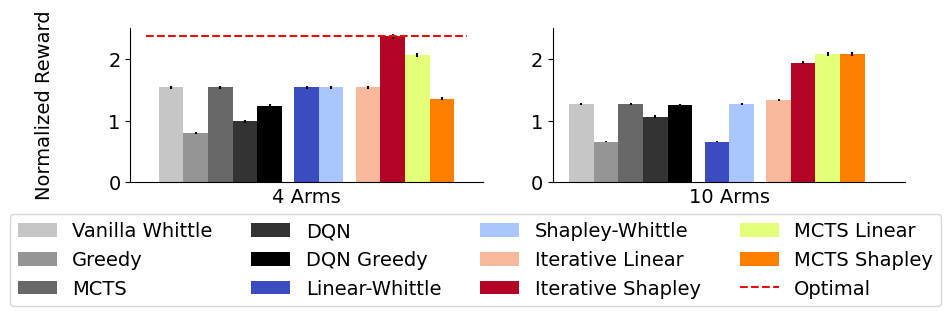

In [14]:
fig, axs = plt.subplots(1,2, figsize=(10, 2))
method_names = ['whittle_activity','greedy','mcts','dqn_step','dqn','linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley','optimal']
nice_names = ["Vanilla Whittle","Greedy","MCTS","DQN","DQN Greedy","Linear-Whittle","Shapley-Whittle","Iterative Linear","Iterative Shapley","MCTS Linear","MCTS Shapley","Optimal"]
width = 0.1
n_arms = [4,10]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 2, 'n_arms': 4, 'time_limit': 100,'prob_distro': 'uniform','reward_type': 'max', 'prob_distro': 'one_time', 'n_episodes': 105}
datasets = ['max_reward']
reward_names = [""]
params = [{}, ]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names[i] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((i+shift)*width)

for i,n in enumerate(n_arms):
    baseline_params['n_arms'] = n
    baseline_params['budget'] = n//2 
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "baselines/all"

        if m in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley','optimal']:
            dataset = "reward_variation/max_reward"

        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['greedy_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")

            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])

            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

            if m == 'mcts_shapley':
                print(max(results['mcts_shapley_reward'][0],results['shapley_iterative_whittle_reward'][0])/(max(results['shapley_whittle_custom_reward'][0],results['linear_whittle_reward'][0])))

    axs[i].set_xticks([])

    axs[i].set_yticks([0,1,2],[0,1,2],fontsize=14)
    axs[i].set_ylim([0,2.5])
    axs[i].set_xlabel("{} Arms".format(n),fontsize=14)


axs[0].set_xlabel("4 Arms",fontsize=14)
axs[1].set_xlabel("10 Arms",fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()
handles[-1] = plt.Line2D([0], [0], color=colors_by_method['optimal'], linestyle='--', label='Horizontal line')

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Normalized Reward",fontsize=14,x=0.03)
fig.savefig("../../results/figures/all_rewards_2.pdf",dpi=300, bbox_inches='tight')


### Impact of Linearity

Linear 1.1718459534780161 1.041304783532086
MCTS 1.825512902580941 1.224034766215555


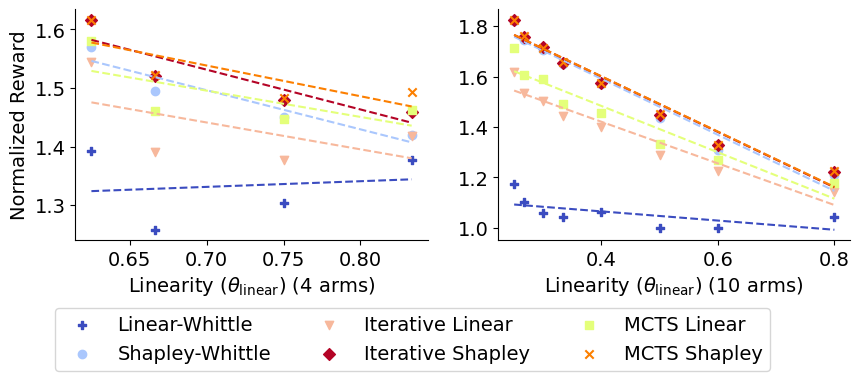

In [8]:
fig, axs = plt.subplots(1,2, figsize=(10, 3))

method_names = ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley']
nice_names = ["Linear-Whittle","Shapley-Whittle","Iterative Linear","Iterative Shapley","MCTS Linear","MCTS Shapley"]

arm_low_high = [(3,1),(3,2),(4,1),(4,2),(4,3),(5,1),(5,2),(5,3),(5,4)]

n_arms = [4,10]

for j,n in enumerate(n_arms):
    x_axis = []
    plots_by_method = {} 
    std_by_method = {}
    for i in method_names:
        plots_by_method[i] = []

    for arm_high,arm_low in arm_low_high:
        params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': n//2,'n_arms': n, 'arm_set_low': arm_low,'arm_set_high': arm_high,'universe_size': 20, 'prob_distro': 'linearity', 'time_limit': 100, 'reward_type': 'set_cover', 'n_episodes': 105}
        dataset = "reward_variation/subset_reward"
        results = get_results_matching_parameters(dataset,"",params)
        x_axis.append(results[0]['ratio'])

        results = aggregate_normalize_data(results,baseline="random")
        
        for method_name in method_names:
            plots_by_method[method_name].append(results['{}_reward'.format(method_name)][0])

    for i,m in enumerate(method_names):
        zipped_values = zip(x_axis,plots_by_method[m])
        zipped_values = [i for i in zipped_values if i[0] < 1.0]
        zipped_values = sorted(zipped_values,key=lambda k: k[0])
        x,y = list(zip(*zipped_values))
        axs[j].scatter(x,y,marker=shapes_by_method[m],color=colors_by_method[m],label=nice_names[i])
        
        coefficients = np.polyfit(x, y, 1)
        slope = coefficients[0]
        intercept = coefficients[1]
        axs[j].plot(x, slope * np.array(x) + intercept,'--', color=colors_by_method[m])

        if m == 'mcts_shapley' and n == 10:
            print("MCTS",y[0],y[-1])
        if m == 'linear_whittle' and n == 10:
            print("Linear",y[0],y[-1])


    # plt.xlim([0.74,1.0])
    axs[j].set_xlabel("Linearity ($\\theta_{\\mathrm{linear}}$)"+" ({} arms)".format(n),fontsize=14)
    axs[j].tick_params(axis='both', which='major', labelsize=14)

    if j == 0:
        axs[j].set_ylabel("Normalized Reward",fontsize=14)
axs[0].legend(fontsize=14,bbox_to_anchor=(2,-0.25),ncol=3)

plt.savefig("../../results/figures/linearity.pdf",dpi=300, bbox_inches='tight')



### Time Taken

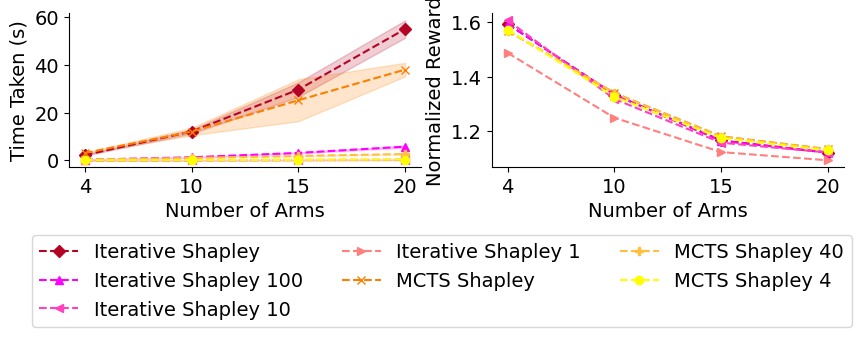

In [11]:
fig, axs = plt.subplots(1,2, figsize=(10, 2))

method_names = ['shapley_iterative_whittle','shapley_iterative_whittle_100','shapley_iterative_whittle_10','shapley_iterative_whittle_1','mcts_shapley','mcts_shapley_40','mcts_shapley_4']
nice_names = ["Iterative Shapley","Iterative Shapley 100","Iterative Shapley 10","Iterative Shapley 1",'MCTS Shapley',"MCTS Shapley 40","MCTS Shapley 4"]
time_taken = [0.01,0.1,1]
width = 0.1
n_arms = [4,10,15,20]

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "reward_variation/subset_reward"

    for n in n_arms:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': 0.5,  'n_arms': n, 'arm_set_low': 6, 'arm_set_high': 8,'prob_distro': 'uniform', 'n_episodes': 105})
        results = aggregate_data(results)
        score_by_n.append(results['{}_time'.format(m)][0]/5)
        std_by_n.append(results['{}_time'.format(m)][1])
    axs[0].fill_between(list(range(len(n_arms))), np.array(score_by_n) - np.array(std_by_n), np.array(score_by_n) + np.array(std_by_n), alpha=0.2,  color=colors_by_method[m])
    axs[0].plot(list(range(len(n_arms))),score_by_n,'{}--'.format(shapes_by_method[m]),color=colors_by_method[m],label=nice_names[i])
axs[0].set_xticks(np.array(list(range(len(n_arms)))),n_arms)
axs[0].set_yticks([0,20,40,60],[0,20,40,60])
axs[0].set_xlabel("Number of Arms",fontsize=14)
axs[0].set_ylabel("Time Taken (s)",fontsize=14)
axs[0].legend(loc="lower right",ncol=3,bbox_to_anchor=(2.25,-1.1))

method_names = ['shapley_iterative_whittle','shapley_iterative_whittle_100','shapley_iterative_whittle_10','shapley_iterative_whittle_1','mcts_shapley','mcts_shapley_40','mcts_shapley_4']
nice_names = ["Iterative Shapley (1000 samples)","Iterative Shapley (100 samples)","Iterative Shapley (10 samples)","Iterative Shapley (1 samples)",'MCTS Shapley (400 iterations)',"MCTS Shapley (40 iterations)","MCTS Shapley (4 iterations)"]
time_taken = [0.01,0.1,1]
width = 0.1
n_arms = [4,10,15,20]

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "reward_variation/subset_reward"

    for n in n_arms:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': 0.5,  'n_arms': n, 'arm_set_low': 6, 'arm_set_high': 8,'prob_distro': 'uniform'})
        num_trials = len(results)
        results = aggregate_normalize_data(results,baseline='random')
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1]/num_trials**.5)
    # plt.fill_between(list(range(len(n_arms))), np.array(score_by_n) - np.array(std_by_n), np.array(score_by_n) + np.array(std_by_n), alpha=0.2,  color=colors_by_method[m])
    plt.plot(list(range(len(n_arms))),score_by_n,'{}--'.format(shapes_by_method[m]),color=colors_by_method[m],label=nice_names[i])
axs[1].set_xticks(np.array(list(range(len(n_arms)))),n_arms)
axs[1].set_xlabel("Number of Arms",fontsize=14)
axs[1].set_ylabel("Normalized Reward",fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)
plt.savefig("../../results/figures/time_reward.pdf",dpi=300, bbox_inches='tight')

### Food Rescue

0.994949764217824
0.9704941281068796


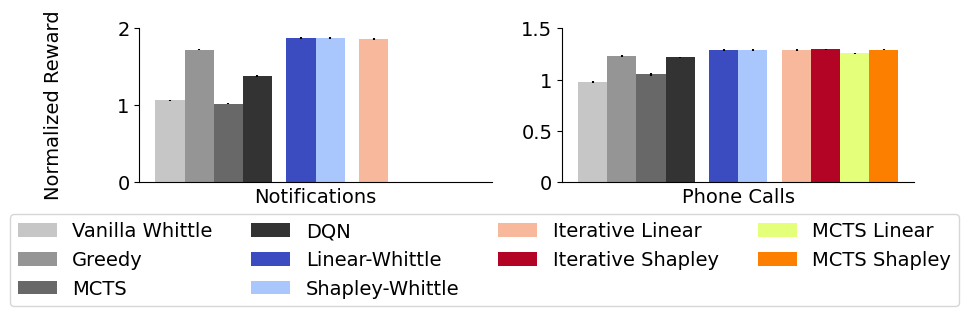

In [12]:
fig, axs = plt.subplots(1,2, figsize=(10, 2))
method_names = ['whittle_activity','greedy','mcts','dqn_step','linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley']
nice_names = ["Vanilla Whittle","Greedy","MCTS","DQN","Linear-Whittle","Shapley-Whittle","Iterative Linear","Iterative Shapley","MCTS Linear","MCTS Shapley"]
width = 0.1
n_arms = [4,10]

params = {'lamb': 0.5, 'time_limit': 100,'n_episodes': 105}
datasets = ['food_resuce_policies']
labels = ["Notifications","Phone Calls"]
reward_names = [""]

x_locations = [] 
shift = 0
for m in range(len(method_names)):
    if method_names[m] == 'linear_whittle':
        shift += 0.5 
    elif method_names[m] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((m+shift)*width)

distros = ["food_rescue","food_rescue_top"]
arm_budget = [(100,1,25),(20,1,10)]
for i in range(len(distros)):

    volunteers = arm_budget[i][0] 
    volunteers_per_arm = arm_budget[i][1]
    budget = arm_budget[i][2]
    params['n_arms'] = volunteers
    params['prob_distro'] = distros[i]
    
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "baselines/food_rescue_policies"

        if m in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_shapley','mcts_linear']:
            dataset = "food_rescue_policies"

        temp_params = deepcopy(params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['greedy_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")

            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])

            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

    axs[i].set_xticks([])

    if i == 0:
        axs[i].set_yticks([0,1,2],[0,1,2],fontsize=14)
        axs[i].set_ylim([0,2])
    else:
        axs[i].set_yticks([0,0.5,1,1.5],[0,0.5,1,1.5],fontsize=14)
        axs[i].set_ylim([0,1.5])


    if i == 0:
        axs[i].set_xlabel("Notifications",fontsize=14)
        print(min(results['linear_whittle_reward'][0],results['shapley_whittle_custom_reward'][0],results['iterative_whittle_reward'][0])/max(results['linear_whittle_reward'][0],results['shapley_whittle_custom_reward'][0],results['iterative_whittle_reward'][0]))
    else:
        print(min(results['linear_whittle_reward'][0],results['shapley_whittle_custom_reward'][0],results['iterative_whittle_reward'][0],results["shapley_iterative_whittle_reward"][0],results["mcts_linear_reward"][0],results["mcts_shapley_reward"][0])/max(results['linear_whittle_reward'][0],results['shapley_whittle_custom_reward'][0],results['iterative_whittle_reward'][0],results["shapley_iterative_whittle_reward"][0],results["mcts_linear_reward"][0],results["mcts_shapley_reward"][0]))
        axs[i].set_xlabel("Phone Calls",fontsize=14)


handles, labels = axs[1].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Normalized Reward",fontsize=14,x=0.03)
fig.savefig("../../results/figures/food_rescue_main.pdf",dpi=300, bbox_inches='tight')


### Ablations

#### Food Rescue Exploration

/tmp/ipykernel_1715048/1690717028.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


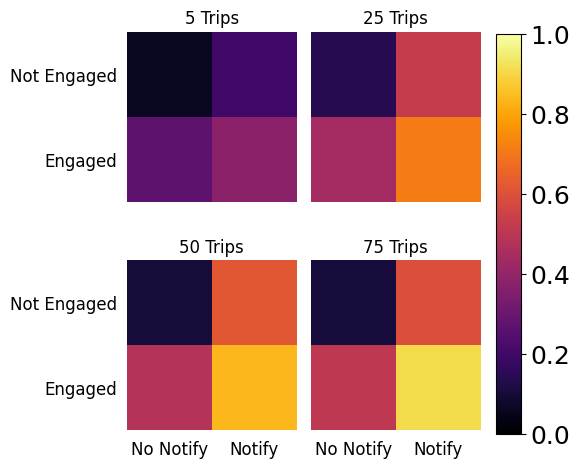

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
all_population_size = 100 
all_transitions = get_all_transitions(all_population_size)
vmax=  1
vmin = 0

transition_sizes = [[3,23],[48,73]]

for i in range(2):
    for j in range(2):
        a = axs[i,j].imshow(all_transitions[transition_sizes[i][j],:,:,1],cmap='inferno',vmax=vmax,vmin=vmin)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].set_title("{} Trips".format(transition_sizes[i][j]+2))

        if i == 1:
            axs[i,j].set_xticks([0,1],['No Notify','Notify'],fontsize=12)
        
        if j == 0:
            axs[i,j].set_yticks([0,1],['Not Engaged','Engaged'],fontsize=12)
        axs[i,j].spines['right'].set_visible(False)
        axs[i,j].spines['top'].set_visible(False)
        axs[i,j].spines['left'].set_visible(False)
        axs[i,j].spines['bottom'].set_visible(False)
        axs[i,j].tick_params(left=False,bottom=False)

# fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([1, 0.1, 0.05, 0.8])
fig.colorbar(a, cax=cbar_ax)

# Adjust layout
plt.tight_layout()
plt.savefig("../../results/figures/transition_distro_food_rescue.pdf",dpi=300, bbox_inches='tight')


/tmp/ipykernel_1715048/1171396222.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ratios, color="blue", shade=True)


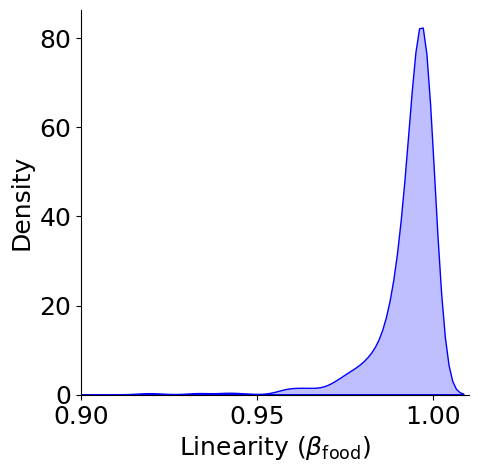

In [14]:
probs_by_user = json.load(open("../../results/food_rescue/match_probs.json","r"))
all_non_zero_probs = np.array([probs_by_user[i] for i in probs_by_user if probs_by_user[i]>0])

plt.figure(figsize=(5,5))

samples = 1000
ratios = []

combination_probs = [math.comb(len(probs_by_user),i) for i in range(1,6)]
combination_probs = np.array(combination_probs)
combination_probs = combination_probs/np.sum(combination_probs)

for i in range(samples):
    choices = np.random.choice(list(range(len(all_non_zero_probs))),random.choices(list(range(1,6)), combination_probs)[0])
    sum_probabilities = np.sum(all_non_zero_probs[choices])
    actual_prob = 1
    for prob in all_non_zero_probs[choices]:
        actual_prob *= (1-prob)
    actual_prob = 1-actual_prob
    ratios.append(actual_prob/sum_probabilities)
sns.kdeplot(ratios, color="blue", shade=True)
plt.xticks([0.9,0.95,1.0])
plt.xlim([0.9,1.01])
plt.xlabel("Linearity ($\\beta_{\\mathrm{food}}$)")
plt.savefig("../../results/figures/food_rescue_distro.pdf",dpi=300, bbox_inches='tight')


/tmp/ipykernel_1715048/11957407.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(all_non_zero_probs, color="blue", shade=True,gridsize=10000)


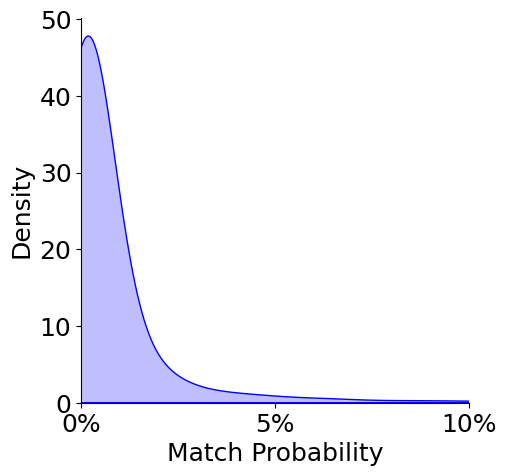

In [15]:
probs_by_user = json.load(open("../../results/food_rescue/match_probs.json","r"))
all_non_zero_probs = np.array([probs_by_user[i] for i in probs_by_user if probs_by_user[i]>0])

plt.figure(figsize=(5,5))

sns.kdeplot(all_non_zero_probs, color="blue", shade=True,gridsize=10000)
plt.xlim([0.0,0.1])
plt.xticks([0,0.05,0.1],['0%','5%','10%'])
plt.xlabel("Match Probability")
plt.savefig("../../results/figures/food_rescue_match_distro.pdf",dpi=300, bbox_inches='tight')


#### Budget/N Arms Ablation

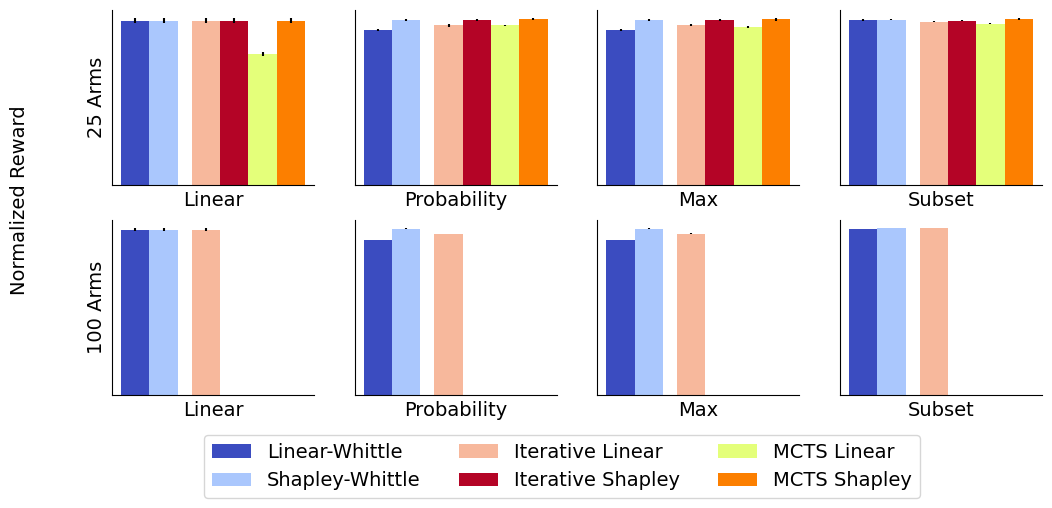

<Figure size 700x400 with 0 Axes>

In [16]:
fig, axs = plt.subplots(2,4, figsize=(12, 5))
method_names = ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley']
nice_names = ["Linear-Whittle","Shapley-Whittle","Iterative Linear","Iterative Shapley","MCTS Linear","MCTS Shapley"]
width = 0.1
plt.figure(figsize=(7,4))
n_arms = [25,100]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 2, 'n_arms': 4, 'time_limit': 100,'prob_distro': 'uniform', 'n_episodes': 105}
datasets = ['linear_reward','prob_reward','max_reward','subset_reward']
reward_names = ["Linear","Probability","Max","Subset"]
params = [{'reward_type': 'linear','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'probability','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'max', 'arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'set_cover', 'universe_size': 20, 'arm_set_low': 6, 'arm_set_high': 8}]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names[i] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((i+shift)*width)

for i,n in enumerate(n_arms):
    for j in range(len(reward_names)):
        baseline_params['n_arms'] = n
        baseline_params['budget'] = n//2 
        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            dataset = "baselines/all"

            if m in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley','optimal']:
                dataset = "reward_variation/{}".format(datasets[j])

            temp_params = deepcopy(baseline_params)
            for p in params[j]:
                temp_params[p] = params[j][p]
                        
            results = get_results_matching_parameters(dataset,"",temp_params)
            num_data = 0
            if len(results)>0:
                num_data = len(results)*len(results[0]['greedy_reward'][0])

            if num_data>0:
                results = aggregate_normalize_data(results,baseline="random")

                if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]
                score_by_n.append(results['{}_reward'.format(m)][0])
                std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
            
                if m == 'optimal' and n == 4:
                    axs[i,j].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])

                else:
                    axs[i,j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

        axs[i,j].set_xticks([])

        # if j != 0:
        axs[i,j].set_yticks([])
        # else:
        #     axs[i,j].set_yticks([0,1,2],[0,1,2],fontsize=14)
        # axs[i,j].set_ylim([0,2.5])
        axs[i,j].set_xlabel(reward_names[j],fontsize=14)

axs[0,0].set_ylabel("25 Arms",fontsize=14)
axs[1,0].set_ylabel("100 Arms",fontsize=14)

handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=3,bbox_to_anchor=(0.5,0.05),fontsize=14)

fig.supylabel("Normalized Reward",fontsize=14,x=0.04)

fig.savefig("../../results/figures/all_rewards_large_N.pdf",dpi=300, bbox_inches='tight')


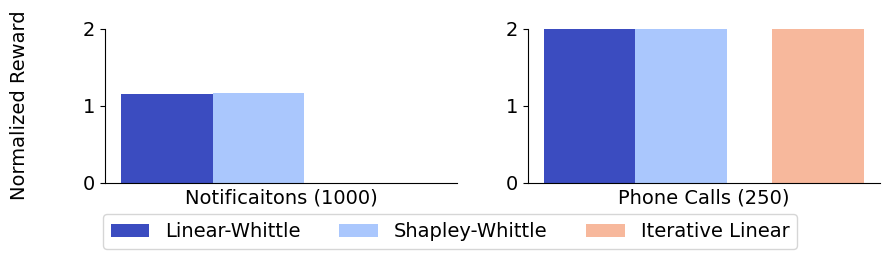

In [17]:
distros = ["food_rescue","food_rescue_top"]
fig, axs = plt.subplots(1,2, figsize=(10, 2))
method_names = ['linear_whittle','shapley_whittle_custom','iterative_whittle']
nice_names = ["Linear-Whittle","Shapley-Whittle","Iterative Linear"]
width = 0.1
n_arms = [4,10]

params = {'lamb': 0.5, 'time_limit': 100,'n_episodes': 5}
datasets = ['food_resuce_policies']
reward_names = [""]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names[i] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((i+shift)*width)

distros = ["food_rescue","food_rescue_top"]
arm_budget = [(100,10,250),(5,50,5)]
for i in range(len(distros)):
    volunteers = arm_budget[i][0] 
    volunteers_per_arm = arm_budget[i][1]
    budget = arm_budget[i][2]
    params['n_arms'] = volunteers
    params['prob_distro'] = distros[i]
    
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "baselines/food_rescue_policies"

        if m in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_shapley','mcts_linear']:
            dataset = "food_rescue_policies"

        temp_params = deepcopy(params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['greedy_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")

            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])

            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

    axs[i].set_xticks([])

    axs[i].set_yticks([0,1,2],[0,1,2],fontsize=14)
    axs[i].set_ylim([0,2])


    if i == 0:
        axs[i].set_xlabel("Notificaitons".format(n),fontsize=14)
    else:
        axs[i].set_xlabel("Phone Calls".format(n),fontsize=14)


axs[0].set_xlabel("Notificaitons (1000)",fontsize=14)
axs[1].set_xlabel("Phone Calls (250)",fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Normalized Reward",fontsize=14,x=0.03)
fig.savefig("../../results/figures/food_rescue_secondary.pdf",dpi=300, bbox_inches='tight')


#### MCTS RL Ablations

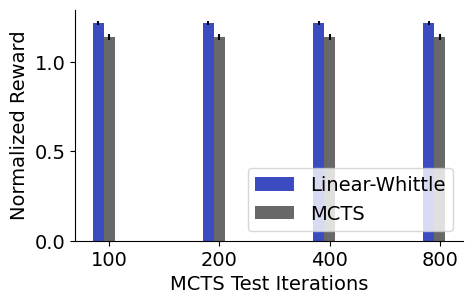

In [18]:
method_names = ['linear_whittle','mcts']
nice_names = ["Linear-Whittle","MCTS"]
mcts_iterations = [100,200,400,800]
width = 0.1
plt.figure(figsize=(5,3))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "baselines/mcts"

    for test_iterations in mcts_iterations:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'budget': 5, 'n_arms': 10, 'mcts_depth': 2, 'test_iterations': test_iterations, 'n_episodes': 5})
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['greedy_reward'][0])
        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")

            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
    plt.bar(np.array(list(range(len(mcts_iterations))))+i*width,score_by_n,width=width,label=nice_names[i],color=colors_by_method[m],yerr=std_by_n)
plt.legend(loc="lower right",fontsize=14)
plt.xticks(np.array(list(range(len(mcts_iterations))))+width*len(method_names)/2,mcts_iterations,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("MCTS Test Iterations",fontsize=14)
plt.ylabel("Normalized Reward",fontsize=14)
plt.savefig("../../results/figures/mcts_iterations.pdf",dpi=300, bbox_inches='tight')

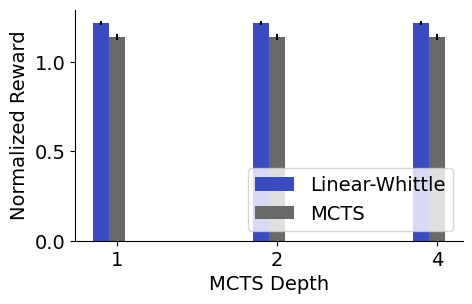

In [19]:
method_names = ['linear_whittle','mcts']
nice_names = ["Linear-Whittle","MCTS"]
mcts_depth = [1,2,4]
width = 0.1
plt.figure(figsize=(5,3))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "baselines/mcts"

    for depth in mcts_depth:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'budget': 5, 'n_arms': 10, 'mcts_depth': depth, 'test_iterations': 400, 'n_episodes': 5})
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['greedy_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")

            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
    plt.bar(np.array(list(range(len(mcts_depth))))+i*width,score_by_n,width=width,label=nice_names[i],color=colors_by_method[m],yerr=std_by_n)
plt.legend(loc="lower right",fontsize=14)
plt.xticks(np.array(list(range(len(mcts_depth))))+width*len(method_names)/2,mcts_depth,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("MCTS Depth",fontsize=14)
plt.ylabel("Normalized Reward",fontsize=14)
plt.savefig("../../results/figures/mcts_depth.pdf",dpi=300, bbox_inches='tight')

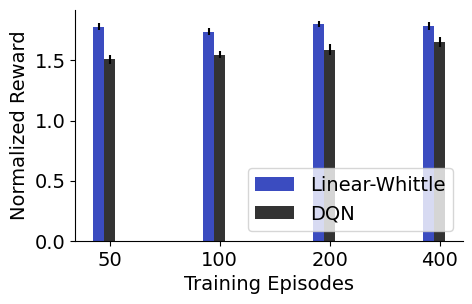

In [20]:
method_names = ["linear_whittle",'dqn_step']
nice_names = ["Linear-Whittle","DQN"]
n_episodes = [50,100,200,400]
width = 0.1
plt.figure(figsize=(5,3))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "baselines/rl"

    for n_episode in n_episodes:
        results = get_results_matching_parameters(dataset,"",{'n_arms': 10,  'volunteers_per_arm': 1,  'n_episodes': n_episode+5, 'time_limit': 100, 'reward_type': 'linear'})
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['greedy_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")

            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
    if m in colors_by_method:
        plt.bar(np.array(list(range(len(n_episodes))))+i*width,score_by_n,width=width,label=nice_names[i],color=colors_by_method[m],yerr=std_by_n)
    else:
        plt.bar(np.array(list(range(len(n_episodes))))+i*width,score_by_n,width=width,label=nice_names[i])
plt.legend(loc="lower right",fontsize=14)
plt.xticks(np.array(list(range(len(n_episodes))))+width*len(method_names)/2,n_episodes,fontsize=14)
plt.xlabel("Training Episodes",fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Normalized Reward",fontsize=14)
plt.savefig("../../results/figures/dqn_ablation.pdf",dpi=300, bbox_inches='tight')

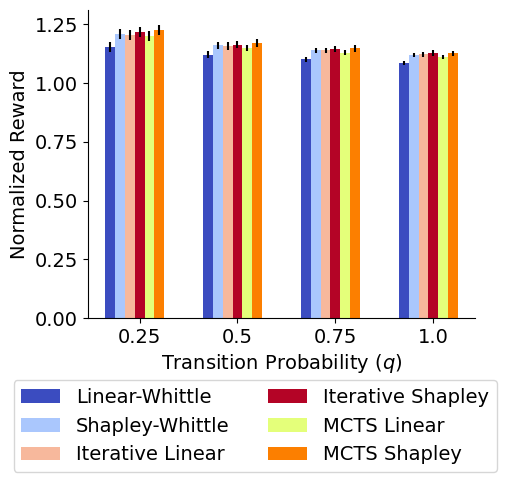

In [21]:
method_names = ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley']
nice_names = ["Linear-Whittle","Shapley-Whittle","Iterative Linear","Iterative Shapley","MCTS Linear","MCTS Shapley"]
min_prob = [0.25,0.5,0.75,1.0]
width = 0.1
plt.figure(figsize=(5,4))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "baselines/synthetic_transitions"

    for prob in min_prob:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 5, 'n_arms': 10, 'max_prob': prob, 'n_episodes': 5})
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['greedy_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")

            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
    plt.bar(np.array(list(range(len(min_prob))))+i*width,score_by_n,width=width,label=nice_names[i],color=colors_by_method[m],yerr=std_by_n)
plt.legend(loc="upper right",bbox_to_anchor=(1.08,-0.17),fontsize=14,ncol=2)
plt.xticks(np.array(list(range(len(min_prob))))+width*len(method_names)/2,min_prob,fontsize=14)
plt.xlabel("Transition Probability ($q$)",fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Normalized Reward",fontsize=14)
plt.savefig("../../results/figures/synthetic_transition.pdf",dpi=300, bbox_inches='tight')

#### Alpha

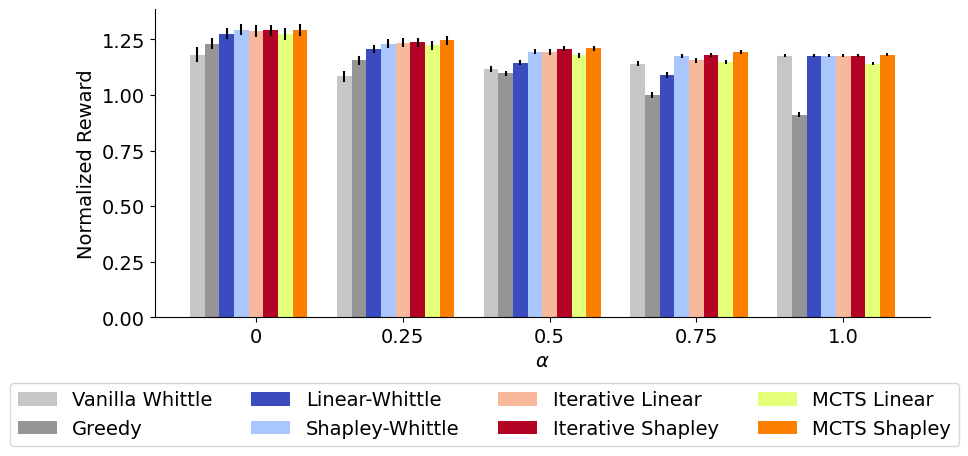

In [22]:
method_names = ['whittle_activity','greedy','linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley']
nice_names = ["Vanilla Whittle","Greedy","Linear-Whittle","Shapley-Whittle","Iterative Linear","Iterative Shapley","MCTS Linear","MCTS Shapley"]
lamb_values = [0,0.25,0.5,0.75,1.0]
width = 0.1
plt.figure(figsize=(10,4))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "reward_variation/max_reward"

    for lamb in lamb_values:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': lamb, 'budget': 5, 'n_arms': 10, 'arm_set_low': 0, 'arm_set_high': 1, 'prob_distro': 'uniform', 'n_episodes': 105})
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['greedy_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")

            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
    plt.bar(np.array(list(range(len(lamb_values))))+i*width,score_by_n,width=width,label=nice_names[i],color=colors_by_method[m],yerr=std_by_n)
plt.legend(loc="lower right",fontsize=14,ncol=4,bbox_to_anchor=(1.05,-0.45))
plt.xticks(np.array(list(range(len(lamb_values))))+width*len(method_names)/2,lamb_values,fontsize=14)
plt.xlabel("$\\alpha$",fontsize=14)
plt.ylabel("Normalized Reward",fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("../../results/figures/alpha.pdf",dpi=300, bbox_inches='tight')

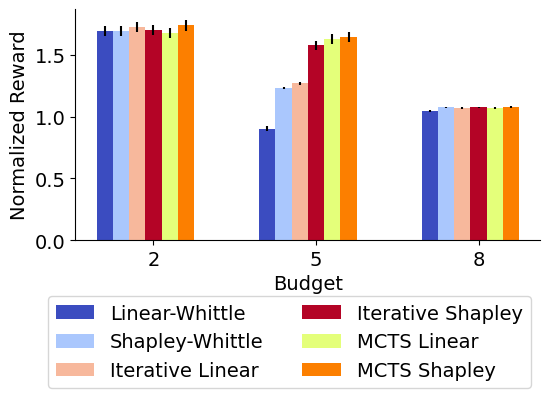

In [23]:
method_names = ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley']
nice_names = ["Linear-Whittle","Shapley-Whittle","Iterative Linear","Iterative Shapley","MCTS Linear","MCTS Shapley"]
budgets = [10//4,10//2,round(10*0.75)]
width = 0.1
plt.figure(figsize=(6,3))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "reward_variation/max_reward"

    for b in budgets:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': b, 'n_arms': 10, 'n_episodes': 105})
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['greedy_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")

            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
    plt.bar(np.array(list(range(len(budgets))))+i*width,score_by_n,width=width,label=nice_names[i],color=colors_by_method[m],yerr=std_by_n)
plt.legend(loc="upper right",fontsize=14,bbox_to_anchor=(1,-0.2),ncol=2)
plt.xticks(np.array(list(range(len(budgets))))+width*len(method_names)/2,budgets,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Budget",fontsize=14)
plt.ylabel("Normalized Reward",fontsize=14)
plt.savefig("../../results/figures/budget.pdf",dpi=300, bbox_inches='tight')